In [15]:
import numpy as np
import matplotlib.pyplot as plt
import arviz
import mici
import time
%matplotlib inline

plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'axes.titlesize': 16,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 10,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.75,
    'grid.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 100,
    'figure.figsize' : (5,5),
    'legend.frameon': False
})

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [16]:
seed = 20200310
rng = np.random.RandomState(seed)

# Manifold Lifting on Toy Example

We consider the observation model

$$y = F(\theta) + \sigma \eta $$

where $F$ is a forward operator on unknown $\theta$ and additive noise $\eta \sim \mathcal{N}(0,\sigma^2) $. As a simple example, we define

$$ F(\theta) = \theta_1^2 + 3 \theta_0^2 \, (\theta_1^2 - 1).$$

Taking $\sigma = 10^{-3}$, we acquire 1 observation $y$, e.g. at location $\theta^\star = (0,1)$ and $\eta^\star = 0$.

In [17]:
def forward_func(theta):
    return theta[1]**2 + 3 * theta[0]**2 * ( theta[0]**2 - 1 )

sigma = 1e-3
theta_truth = np.array([0.,1.])
eta_truth = 0.
y = forward_func(theta_truth) + eta_truth * sigma #y = 1.0

The goal of the inference is then to identify the set of $\theta$ values that explain the observed $y = 1$. Placing a standard Gaussian prior over $\theta$, the goal of this inverse problem is to infer the set of $\theta$ given $y$. 

$$ \theta \sim \mathcal{N}(0,I_2) $$

$$ y | \theta \sim \mathcal{N}( F(\theta) ,\sigma^2) $$

and the posterior density reads

$$ - \text{log} \, p \, (\theta | y) \propto \frac{\theta^T \theta}{2} +  \frac{y -  F(\theta)}{2 \sigma^2}.$$

As $\sigma \rightarrow 0$, the posterior tend towards a limiting manifold $S$. To help with visualisation, we can plot $S$ by solving explicitly $\theta_1$ in terms of $\theta_0$ for $F(\theta) = y = 1$, i.e. when $\sigma$ is $0$.

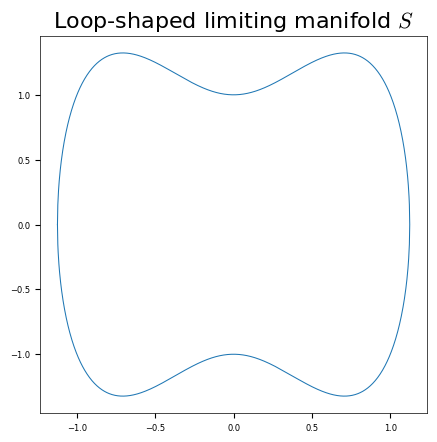

In [18]:
def plot_manifold(fig, ax):
    '''plotting the limiting manifold'''
    def generate_theta_1(theta_0):
        return np.sqrt( 1 - 3 * theta_0**2 * ( theta_0**2 - 1 ) )

    theta_0 = np.linspace( -np.sqrt(0.5 + np.sqrt(21)/6 ) + 1e-10 , np.sqrt(0.5 + np.sqrt(21)/6 ) - 1e-10 , 1000)
    theta_1 = generate_theta_1(theta_0)
    theta_0_full, theta_1_full = np.concatenate([theta_0,theta_0[::-1]]), np.concatenate([theta_1,-theta_1[::-1]])    
    ax.plot(theta_0_full, theta_1_full)
    
    return fig, ax

fig = plt.figure()
ax = plt.subplot(111)
_ , ax = plot_manifold(fig, ax)
ax.set_title('Loop-shaped limiting manifold $S$');

## Standard HMC

We use standard HMC for inference in this unconstrained setting.To run HMC with `mici`, all we need are the functions for:

- potential energy
- gradient of potential energy (optional)

If the gradient is not specified, `mici` will use `autograd` to compute it. In this example, the gradient is simple enough to be derived by hand, which has the advantage of a faster runtime than the `autograd` default.

In [19]:
def hmc_pot_energy(theta):
    return np.sum(theta**2) / 2 + (y - forward_func(theta))**2 / (2 * sigma**2)

def hmc_grad_pot_energy(theta):
    '''analytic gradient for potential energy'''
    return theta - (y - forward_func(theta))/sigma**2 * np.array([12 * theta[0]**3 - 6 * theta[0] , 2*theta[1]])

Now, we may define the system object by parsing the inputs of potential energy and its gradient. We then define the numerical integrator and a No-U-Turn sampler. We choose the step size to be 3 times smaller than $\sigma$. Attempts to increase the step size has been met with poor acceptance. (try it out yourself!)

In [20]:
#system
hmc_system = mici.systems.EuclideanMetricSystem(neg_log_dens=hmc_pot_energy,
                                                grad_neg_log_dens=hmc_grad_pot_energy)

#integrator
hmc_step_size = 0.3 * sigma
hmc_integrator = mici.integrators.ExplicitLeapfrogIntegrator(system=hmc_system, step_size=hmc_step_size)

#sampler
hmc_sampler = mici.samplers.DynamicMultinomialHMC(system=hmc_system, integrator=hmc_integrator, rng=rng)

We will run 2 chains (in parallel), so we now initialise the chains at two far-away $\theta$ locations on $S$.

In [21]:
num_chains = 2
theta_init_list = [ np.array([1., 1.]), np.array([-1., -1.])]

In [22]:
hmc_states_init = []
for i in range(num_chains):
    u_init = theta_init_list[i]
    state = mici.states.ChainState(pos=u_init.copy(), mom=None, dir=1 , _call_counts={})
    hmc_states_init.append(state)

Off we sample!

In [25]:
num_samples = 1000
hmc_start_time= time.time()
hmc_final_states, hmc_traces, hmc_stats = hmc_sampler.sample_chains(n_sample=num_samples,
                                                                    init_states= theta_init_list,
                                                                    n_process=num_chains)
hmc_end_time = time.time()

Chain 1/2: 100%|██████████|1000/1000 [01:42<00:00, 9.75it/s, accept_prob=0.957]

Chain 2/2: 100%|██████████|1000/1000 [01:38<00:00, 10.20it/s, accept_prob=0.934]

In [26]:
print(f'Time taken: {hmc_end_time - hmc_start_time:.2f} seconds')

Time taken: 102.67 seconds


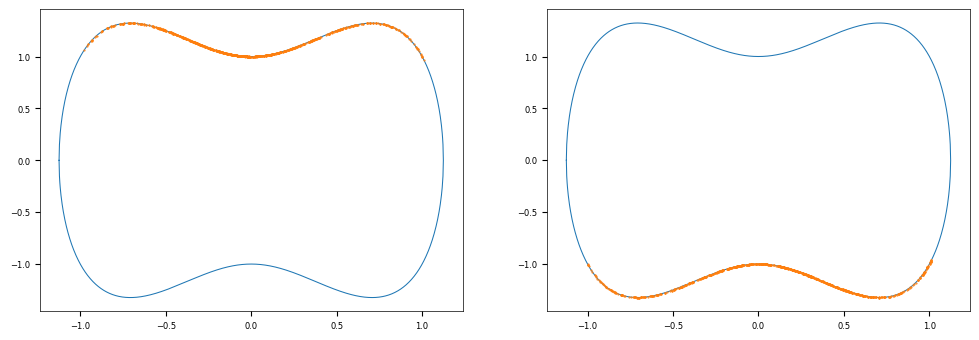

In [27]:
def plot_traces(traces):
    '''helper function to plot mcmc samples over limiting manifold'''
    trace_1, trace_2 = traces['pos'][0], traces['pos'][1]
    fig = plt.figure(figsize = (12,4))
    ax_1 = plt.subplot(1,2,1)
    _ , ax_1 = plot_manifold(fig, ax_1)
    ax_1.plot(trace_1[:,0], trace_1[:,1], '.', markersize = 1.)

    ax_2 = plt.subplot(1,2,2)
    _, ax_2 = plot_manifold(fig, ax_2)
    ax_2.plot(trace_2[:,0], trace_2[:,1], '.', markersize = 1.);
    
plot_traces(hmc_traces)

## Riemannian Manifold HMC (RM-HMC)

To run RM-HMC, we need to additionally define the Riemannian metric. Here, we also optionally define the function which computes the product of a vector and the Jacobian metric.

In [28]:
def metric(theta):
    J = np.array( [[ 12 * theta[0]**3 - 6 * theta[0] , 2 * theta[1] ]] ).T

    return J @ J.T / sigma**2 + np.eye(2)

def vjp_metric_func(theta):
    theta_0, theta_1 = theta[0], theta[1]
    dM_dtheta = np.array([
        [[(864 * theta_0**5 - 576 * theta_0**3 + 72 * theta_0), 12 * theta_1 * (6 * theta_0**2 - 1)],
         [12 * theta_1 * (6 * theta_0**2 - 1), 0]],
        [[0, (24 * theta_0**3 - 12 * theta_0)],
         [(24 * theta_0**3 - 12 * theta_0), 8 * theta_1]],
    ]) / sigma**2

    return lambda V : np.sum(V[None, :, :] * dM_dtheta[:, :, :], axis=(1, 2))

Once again, we define the relevant `mici` objects for RM-HMC and sampling is underway.

In [29]:
#rm-hmc system object
rm_system = mici.systems.DenseRiemannianMetricSystem(neg_log_dens= hmc_pot_energy,
                                                 grad_neg_log_dens= hmc_grad_pot_energy,
                                                 metric_func =  metric,
                                                 vjp_metric_func= vjp_metric_func)

#defining integrator and sampler object
rm_step_size = 0.3 * sigma
rm_integrator = mici.integrators.ImplicitLeapfrogIntegrator(system=rm_system, step_size=rm_step_size)
rm_sampler = mici.samplers.DynamicMultinomialHMC(system=rm_system, integrator=rm_integrator, rng=rng)

#start sampling
rm_start_time = time.time()
rm_final_states, rm_traces, rm_stats = rm_sampler.sample_chains(
    n_sample=num_samples,
    init_states=theta_init_list,
    n_process=num_chains, 
    monitor_stats=['accept_prob', 'n_step', 'convergence_error', 'non_reversible_step'])
rm_end_time = time.time()

Chain 1/2: 100%|██████████|1000/1000 [13:47<00:00, 1.21it/s, accept_prob=0.865, n_step=61.9, convergence_error=0.136, non_reversible_step=0.00]

Chain 2/2: 100%|██████████|1000/1000 [09:03<00:00, 1.84it/s, accept_prob=0.747, n_step=34.4, convergence_error=0.259, non_reversible_step=0.00]

In [30]:
print(f'Time taken: {rm_end_time - rm_start_time:.2f} seconds')

Time taken: 827.21 seconds


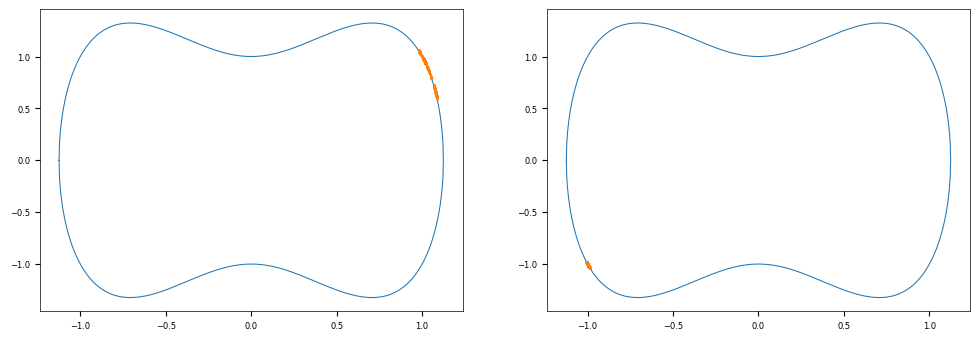

In [31]:
plot_traces(rm_traces)

## Constrained HMC (C-HMC)

We lift our 2D problem onto a submanifold embedded in 3D space. The noise variable $\eta$ augments the original parameter $\theta$-space to result in the extended $q$-space, where $q = (\theta, \eta)$. This gives a posterior $q | y$ that lives on the submanifold ${ (\theta, \eta): F(\theta) + \sigma \eta - y = 0}$ in 3D, with the posterior of interest $\theta|y$ as $\theta$-marginal.

To run C-HMC, we define the functions for:

- potential energy $\equiv$ negative log posterior in $q$-space
- gradient of potential energy (optional)
- constraint equation, $c(q) = F(\theta) + \sigma \eta - y$
- Jacobian of constraint (optional)

In [32]:
def jacob_constr(q):
    return np.array([[ 12 * q[0]**3 - 6 * q[0] , 2*q[1] , sigma ]])
    
def constr(q):
    theta, n = q[:2], q[2:]
    return  forward_func(theta) + sigma*n - y

def pot_energy(q): 
    return np.sum(q**2) / 2 + 0.5 * np.log(144*q[0]**6 - 144*q[0]**4 + 36*q[0]**2  + 4*q[1]**2 + sigma**2)

def grad_pot_energy(q): 
    return q +  0.5 / (144*q[0]**6 - 144*q[0]**4 + 36*q[0]**2  + 4*q[1]**2 + sigma**2) * np.array(
        [6 * 144 * q[0] ** 5 - 4 * 144 * q[0] ** 3 + 2 * 36 * q[0],
         8 * q[1],
         0])

Now that we are working in the $q$-space, our initialisations are to be augmented with the $\eta$ component. We can determine $\eta$ from the constraint equation.

In [36]:
q_init_list = []

for theta in theta_init_list:
    eta = (y - forward_func(theta)) / sigma
    q_init_list.append(np.concatenate((theta,[eta])))

Correspondingly, we use a constrained system and a constrained leapfrog integrator.

In [37]:
chmc_system = mici.systems.DenseConstrainedEuclideanMetricSystem(neg_log_dens=pot_energy,
                                                            constr=constr,
                                                            grad_neg_log_dens=grad_pot_energy,
                                                            jacob_constr=jacob_constr)

In [41]:
chmc_step_size = 2e-1 #kept constant for varying sigma values
chmc_integrator = mici.integrators.ConstrainedLeapfrogIntegrator(system=chmc_system, step_size=chmc_step_size)
chmc_sampler = mici.samplers.DynamicMultinomialHMC(system=chmc_system, integrator=chmc_integrator, rng=rng)

chmc_start_time = time.time()
chmc_final_states, chmc_traces, chmc_stats = chmc_sampler.sample_chains(
    n_sample=num_samples,
    init_states=q_init_list,
    n_process=num_chains,
    monitor_stats=['accept_prob', 'n_step', 'convergence_error', 'non_reversible_step'])
chmc_end_time = time.time()

Chain 1/2: 100%|██████████|1000/1000 [00:43<00:00, 23.23it/s, accept_prob=0.918, n_step=10.3, convergence_error=0.344, non_reversible_step=0.00]

Chain 2/2: 100%|██████████|1000/1000 [00:42<00:00, 23.37it/s, accept_prob=0.915, n_step=10.1, convergence_error=0.342, non_reversible_step=0.00]

In [42]:
print(f'Time taken: {chmc_end_time - chmc_start_time:.2f} seconds')

Time taken: 43.26 seconds


We consider only the first two $\theta$ components of the MCMC samples by dropping the last $\eta$ component.

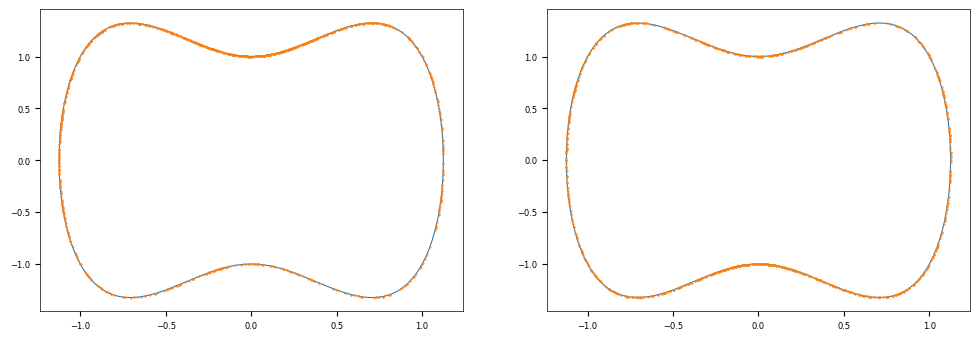

In [43]:
plot_traces(chmc_traces)

Visually, the trace plots for C-HMC does a better job than standard HMC and RM-HMC in sampling the posterior of $\theta$. This toy example shows the susceptibility of unconstrained MCMC methods towards sampling posteriors that concentrate around a low-dimensional manifold. Attempts to increase the step size of the unconstrained samplers are met with poor acceptances. While the unconstrained methods deteriorates as $\sigma \rightarrow 0$, our manifold-lifting approach is demonstrably robust to a vanishing noise. We can also compare the effective sample size (ESS) to quantify the performance of the different MCMC algorithms.

In [44]:
hmc_ess = np.array(arviz.ess(hmc_traces, method='bulk').pos) / num_chains
rm_ess = np.array(arviz.ess(rm_traces, method='bulk').pos) / num_chains
chmc_ess = np.array(arviz.ess(chmc_traces, method='bulk').pos)[:2] / num_chains
    
hmc_rhat = np.array(arviz.rhat(hmc_traces, method='rank').pos)
rm_rhat = np.array(arviz.rhat(rm_traces, method='rank').pos)
chmc_rhat = np.array(arviz.rhat(chmc_traces, method='rank').pos)[:2]

print(f'Rhat (standard HMC): {hmc_rhat}')
print(f'Rhat (RM-HMC): {rm_rhat}')
print(f'Rhat (C-HMC): {chmc_rhat}')
print('------------------------------------------------')
print(f'ESS/second (standard HMC): {hmc_ess/(hmc_end_time - hmc_start_time)}')
print(f'ESS/second (RM-HMC): {rm_ess/(rm_end_time - rm_start_time)}')
print(f'ESS/second (C-HMC): {chmc_ess/(chmc_end_time - chmc_start_time)}')

Rhat (standard HMC): [1.07846115 1.82650765]
Rhat (RM-HMC): [2.46293451 2.45344985]
Rhat (C-HMC): [1.00517761 1.07147085]
------------------------------------------------
ESS/second (standard HMC): [0.15186173 0.01462643]
ESS/second (RM-HMC): [0.00148915 0.00148899]
ESS/second (C-HMC): [1.22791984 0.65878594]
